In [1]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mfurkanyumsak","key":"52931142e2c26962b8e293cfdc5f00f4"}'}

In [2]:
# 📌 Upload your kaggle.json API key manually from the left panel
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 📌 Install Kaggle API
!pip install -q kaggle

In [3]:
# 🔽 Download dataset
!kaggle competitions download -c tabular-playground-series-sep-2021

# 📦 Unzip
!unzip -q tabular-playground-series-sep-2021.zip


 88% 527M/597M [00:00<00:00, 1.35GB/s]
100% 597M/597M [00:00<00:00, 1.35GB/s]


In [4]:
# EDA

# 📦 Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_solution.csv")

# 🧾 Shape and preview
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Sample submission shape:", sample_submission.shape)

# 🔍 Preview training data
train_df.head()


Train shape: (957919, 120)
Test shape: (493474, 119)
Sample submission shape: (493474, 2)


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [5]:
# 📄 View all column names in the train dataset
print(train_df.columns)


Index(['id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118',
       'claim'],
      dtype='object', length=120)


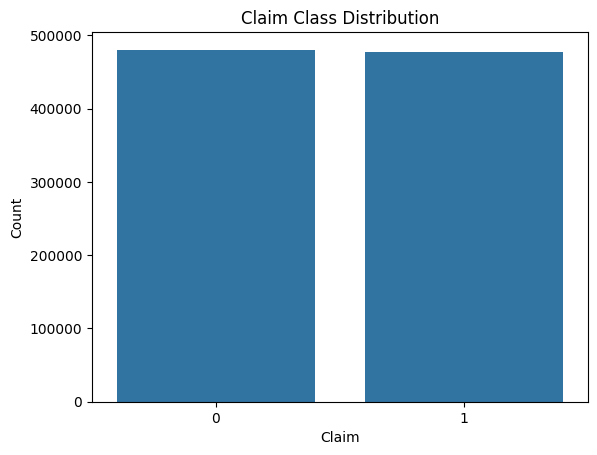

claim
0    0.501508
1    0.498492
Name: proportion, dtype: float64


In [6]:
# Target Distribution

# 📊 Class distribution for 'claim'
sns.countplot(x='claim', data=train_df)
plt.title("Claim Class Distribution")
plt.xlabel("Claim")
plt.ylabel("Count")
plt.show()

# 📉 Percentage of each class
claim_distribution = train_df['claim'].value_counts(normalize=True)
print(claim_distribution)


In [7]:
#  Missing Value Check

# 🧼 Check for missing values
missing = train_df.isnull().sum()
missing = missing[missing > 0]
print("Missing values in train set:\n", missing)


Missing values in train set:
 f1      15247
f2      15190
f3      15491
f4      15560
f5      15405
        ...  
f114    15438
f115    15559
f116    15589
f117    15407
f118    15212
Length: 118, dtype: int64


In [8]:
# Feature Type & Distribution Check

# 📄 Check data types
print(train_df.dtypes.value_counts())

# 🎯 Feature columns (excluding id and target)
feature_cols = [col for col in train_df.columns if col not in ['id', 'claim']]
print("Number of features:", len(feature_cols))


float64    118
int64        2
Name: count, dtype: int64
Number of features: 118


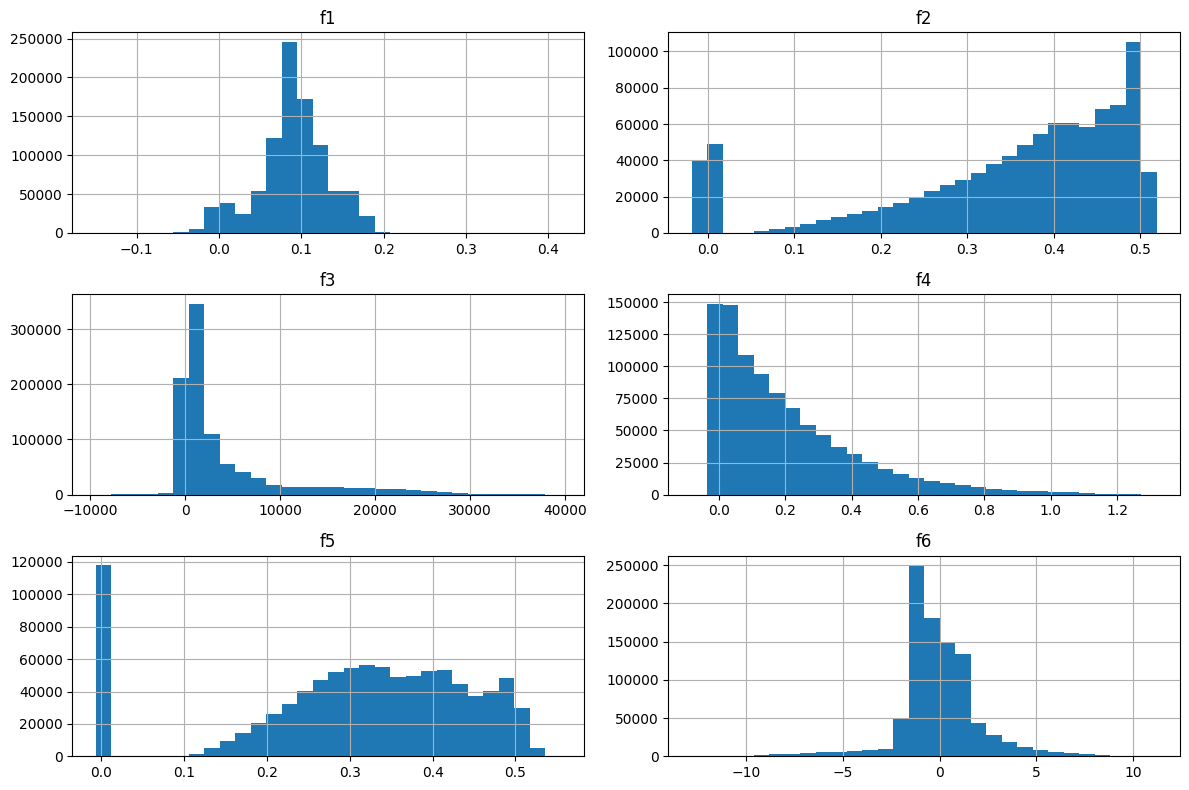

In [9]:
# 📊 Distribution of first few features
train_df[feature_cols[:6]].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()


In [10]:
train_df['feature_sum'] = train_df[feature_cols].sum(axis=1)
train_df['feature_mean'] = train_df[feature_cols].mean(axis=1)
train_df['feature_std'] = train_df[feature_cols].std(axis=1)


In [11]:
# Model Traininig

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 🎯 Feature and target setup
X = train_df[feature_cols]
y = train_df['claim']

# 🔀 Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 🚀 Model
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# 📈 Predict and evaluate
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

print("📌 Classification Report:\n", classification_report(y_val, y_pred))
print("📌 ROC-AUC Score:", roc_auc_score(y_val, y_proba))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75     96081
           1       0.76      0.71      0.73     95503

    accuracy                           0.74    191584
   macro avg       0.74      0.74      0.74    191584
weighted avg       0.74      0.74      0.74    191584

📌 ROC-AUC Score: 0.7941248641121785


📌 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75     96081
           1       0.76      0.71      0.73     95503

    accuracy                           0.74    191584
   macro avg       0.74      0.74      0.74    191584
weighted avg       0.74      0.74      0.74    191584

📌 ROC-AUC Score: 0.7941248641121785


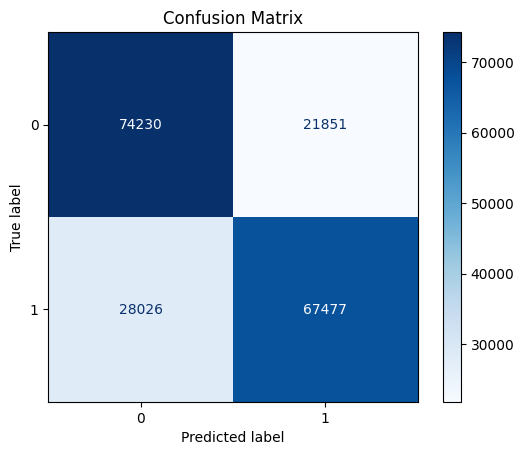

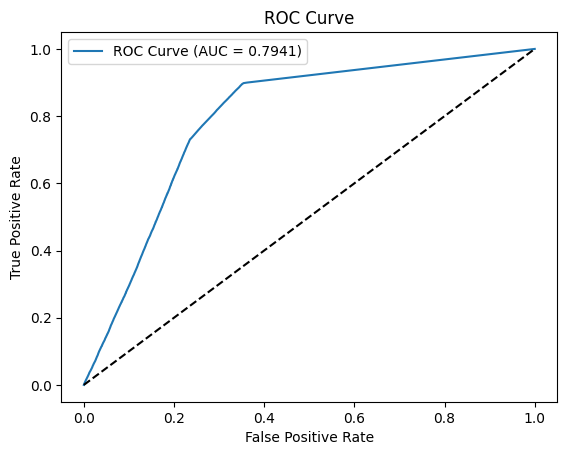

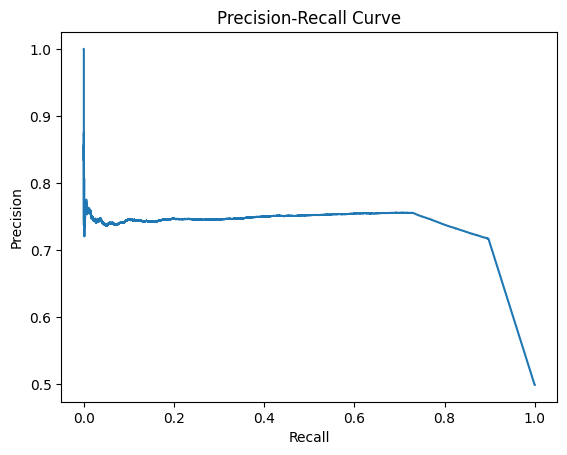

In [12]:
# Model Performance

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Classification Report & ROC-AUC
print("📌 Classification Report:\n", classification_report(y_val, y_pred))
print("📌 ROC-AUC Score:", roc_auc_score(y_val, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [13]:
# Feature Engineering

# Add simple statistical features
train_df['f_sum'] = train_df[feature_cols].sum(axis=1)
train_df['f_mean'] = train_df[feature_cols].mean(axis=1)
train_df['f_std'] = train_df[feature_cols].std(axis=1)
train_df['f_min'] = train_df[feature_cols].min(axis=1)
train_df['f_max'] = train_df[feature_cols].max(axis=1)

# Same Work for Test Data
test_df['f_sum'] = test_df[feature_cols].sum(axis=1)
test_df['f_mean'] = test_df[feature_cols].mean(axis=1)
test_df['f_std'] = test_df[feature_cols].std(axis=1)
test_df['f_min'] = test_df[feature_cols].min(axis=1)
test_df['f_max'] = test_df[feature_cols].max(axis=1)


In [14]:
# Update feature list with new engineered features

extended_features = feature_cols + ['f_sum', 'f_mean', 'f_std', 'f_min', 'f_max']


In [15]:
# Model Traininig Again

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 🎯 Data preparation
X = train_df[extended_features]
y = train_df['claim']

# 🔀 Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 🚀 Train updated model
model_fe = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_fe.fit(X_train, y_train)

# 📈 Predict and evaluate
y_pred = model_fe.predict(X_val)
y_proba = model_fe.predict_proba(X_val)[:, 1]

print("📌 Classification Report:\n", classification_report(y_val, y_pred))
print("📌 ROC-AUC Score:", roc_auc_score(y_val, y_proba))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75     96081
           1       0.76      0.71      0.73     95503

    accuracy                           0.74    191584
   macro avg       0.74      0.74      0.74    191584
weighted avg       0.74      0.74      0.74    191584

📌 ROC-AUC Score: 0.7942452672988902


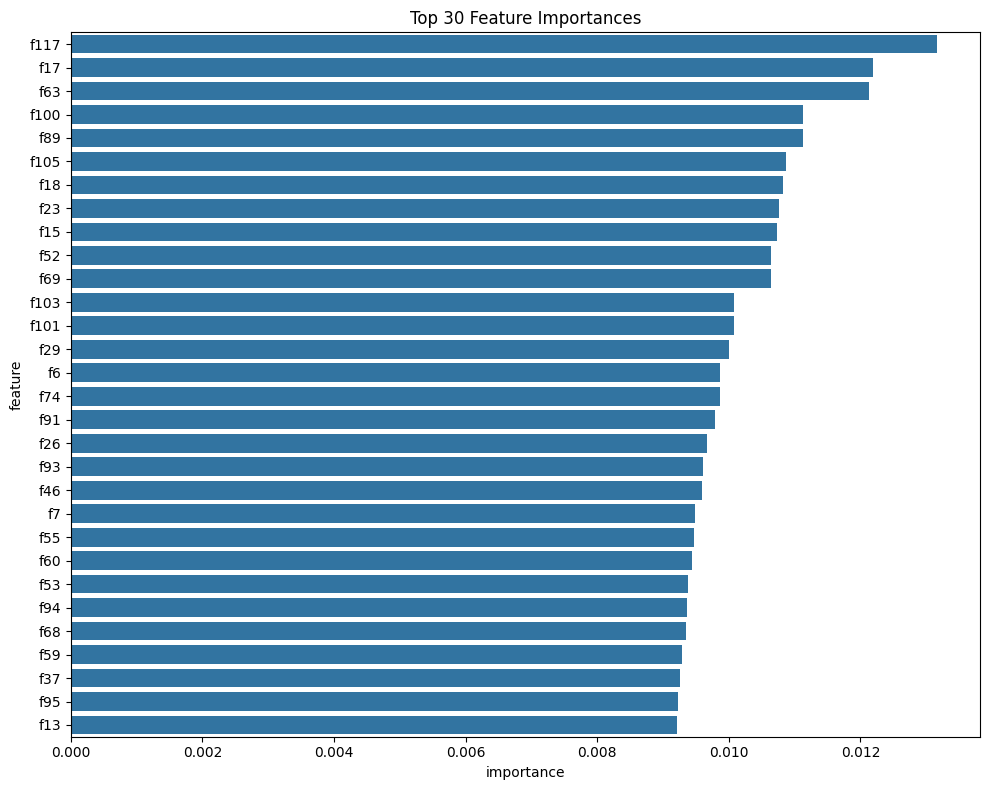

In [16]:
# Feature Importance Calculating

import matplotlib.pyplot as plt
import numpy as np

# Get feature importance

importances = model_fe.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': extended_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 30 important features

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30))
plt.title("Top 30 Feature Importances")
plt.tight_layout()
plt.show()


In [17]:
# Select top 50 features
top_50_features = feature_importance_df['feature'].head(50).tolist()


In [18]:
import lightgbm as lgb

# Train / Test Split
X_top50 = train_df[top_50_features]
y = train_df['claim']

# Split
X_train, X_val, y_train, y_val = train_test_split(X_top50, y, test_size=0.2, random_state=42)

# Model
model_top50 = lgb.LGBMClassifier(random_state=42)
model_top50.fit(X_train, y_train)

# Predict
y_pred = model_top50.predict(X_val)
y_proba = model_top50.predict_proba(X_val)[:, 1]


[LightGBM] [Info] Number of positive: 382084, number of negative: 384251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12733
[LightGBM] [Info] Number of data points in the train set: 766335, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005656
[LightGBM] [Info] Start training from score -0.005656


              precision    recall  f1-score   support

           0       0.70      0.75      0.73     96153
           1       0.73      0.68      0.70     95431

    accuracy                           0.72    191584
   macro avg       0.72      0.71      0.71    191584
weighted avg       0.72      0.72      0.71    191584

 ROC-AUC Score (Top 50): 0.7296


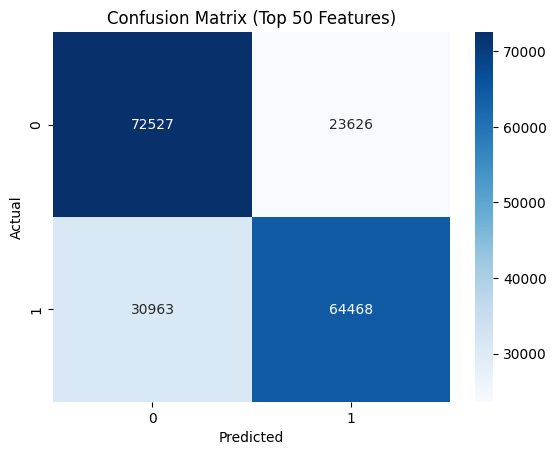

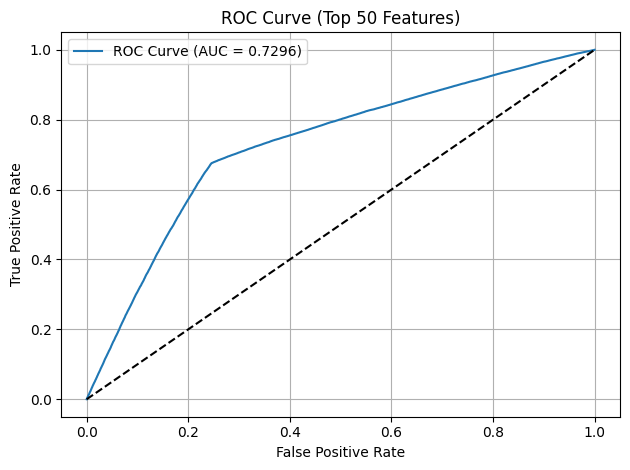

In [19]:
# Evaluate Performance

# Evaluation
print(classification_report(y_val, y_pred))
print(f" ROC-AUC Score (Top 50): {roc_auc_score(y_val, y_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Top 50 Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = roc_auc_score(y_val, y_proba)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.title("ROC Curve (Top 50 Features)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.9 MB/s eta 0:00:00


In [21]:
# Hyperparameter Optimization

import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import numpy as np

# Split the training data for evaluation
X_train_opt, X_valid_opt, y_train_opt, y_valid_opt = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    # Train LightGBM with the suggested parameters
    model = LGBMClassifier(**params)
    model.fit(X_train_opt, y_train_opt)
    y_pred = model.predict_proba(X_valid_opt)[:, 1]
    auc = roc_auc_score(y_valid_opt, y_pred)

    return auc

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best ROC-AUC score
print("Best AUC Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)


[I 2025-07-22 14:46:51,758] A new study created in memory with name: no-name-f1be9d49-51cc-469f-a210-ce05a9eec9de


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:47:09,297] Trial 0 finished with value: 0.728926174501787 and parameters: {'n_estimators': 981, 'learning_rate': 0.04148512356507445, 'num_leaves': 31, 'max_depth': 3, 'min_child_samples': 90, 'subsample': 0.4481456081633887, 'colsample_bytree': 0.8882826970911643, 'reg_alpha': 0.004686662368392628, 'reg_lambda': 9.251474090308125e-06}. Best is trial 0 with value: 0.728926174501787.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:47:20,995] Trial 1 finished with value: 0.7272852022276941 and parameters: {'n_estimators': 325, 'learning_rate': 0.08723568582486353, 'num_leaves': 113, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7199078838713793, 'colsample_bytree': 0.7464229224864458, 'reg_alpha': 0.5348086788637674, 'reg_lambda': 3.659804461425844e-07}. Best is trial 0 with value: 0.728926174501787.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:47:26,508] Trial 2 finished with value: 0.7202376638048763 and parameters: {'n_estimators': 264, 'learning_rate': 0.0204433337098785, 'num_leaves': 20, 'max_depth': 8, 'min_child_samples': 39, 'subsample': 0.8274351810096274, 'colsample_bytree': 0.9553176616817776, 'reg_alpha': 0.02871022321276841, 'reg_lambda': 2.5679036644875697e-06}. Best is trial 0 with value: 0.728926174501787.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:48:37,042] Trial 3 finished with value: 0.7204099213226092 and parameters: {'n_estimators': 984, 'learning_rate': 0.11390292204357101, 'num_leaves': 320, 'max_depth': 11, 'min_child_samples': 96, 'subsample': 0.8684486941526711, 'colsample_bytree': 0.6751734702676022, 'reg_alpha': 8.276321738468775, 'reg_lambda': 4.474099068384335e-05}. Best is trial 0 with value: 0.728926174501787.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:48:45,476] Trial 4 finished with value: 0.7195576196316056 and parameters: {'n_estimators': 457, 'learning_rate': 0.011394341668648, 'num_leaves': 103, 'max_depth': 3, 'min_child_samples': 76, 'subsample': 0.6288876901914959, 'colsample_bytree': 0.7668471999167152, 'reg_alpha': 0.00038986698183041867, 'reg_lambda': 6.7194029784936694e-06}. Best is trial 0 with value: 0.728926174501787.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:49:07,521] Trial 5 finished with value: 0.7272813411064445 and parameters: {'n_estimators': 519, 'learning_rate': 0.06875630438089456, 'num_leaves': 286, 'max_depth': 10, 'min_child_samples': 74, 'subsample': 0.9839856219873852, 'colsample_bytree': 0.5214440964832225, 'reg_alpha': 1.0851581482593062e-07, 'reg_lambda': 1.6774438624841673e-09}. Best is trial 0 with value: 0.728926174501787.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:50:10,051] Trial 6 finished with value: 0.7202544266903724 and parameters: {'n_estimators': 809, 'learning_rate': 0.10126443304224657, 'num_leaves': 1762, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.5514997579549762, 'colsample_bytree': 0.5353499709975568, 'reg_alpha': 2.9233967720947195e-05, 'reg_lambda': 0.00662652123109893}. Best is trial 0 with value: 0.728926174501787.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:50:36,042] Trial 7 finished with value: 0.7295897324110155 and parameters: {'n_estimators': 992, 'learning_rate': 0.023926568132286732, 'num_leaves': 29, 'max_depth': 14, 'min_child_samples': 87, 'subsample': 0.6093383187933994, 'colsample_bytree': 0.7799153529667586, 'reg_alpha': 0.0002408829252851156, 'reg_lambda': 3.8161169658862866e-07}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:50:39,953] Trial 8 finished with value: 0.7273610031470564 and parameters: {'n_estimators': 106, 'learning_rate': 0.1307918991409705, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 57, 'subsample': 0.9853244732951688, 'colsample_bytree': 0.5199066777156726, 'reg_alpha': 3.641765780879223e-06, 'reg_lambda': 1.4468838682669384e-06}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:52:04,375] Trial 9 finished with value: 0.7214999414786838 and parameters: {'n_estimators': 718, 'learning_rate': 0.09498750626045065, 'num_leaves': 924, 'max_depth': 13, 'min_child_samples': 39, 'subsample': 0.7663151358530164, 'colsample_bytree': 0.9307884429440678, 'reg_alpha': 0.13427706047573898, 'reg_lambda': 5.885277326347916e-07}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:52:22,686] Trial 10 finished with value: 0.7257975310262378 and parameters: {'n_estimators': 736, 'learning_rate': 0.14679671636094171, 'num_leaves': 52, 'max_depth': 15, 'min_child_samples': 67, 'subsample': 0.4091754391572834, 'colsample_bytree': 0.6396357121169709, 'reg_alpha': 1.2142956100694647e-09, 'reg_lambda': 9.443795579441325}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:52:40,849] Trial 11 finished with value: 0.726593671239991 and parameters: {'n_estimators': 944, 'learning_rate': 0.19941748968659662, 'num_leaves': 21, 'max_depth': 6, 'min_child_samples': 97, 'subsample': 0.45045122097507356, 'colsample_bytree': 0.8507091242327197, 'reg_alpha': 0.0016161665013846966, 'reg_lambda': 2.4555838058543545e-09}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:52:56,014] Trial 12 finished with value: 0.7292135795097967 and parameters: {'n_estimators': 901, 'learning_rate': 0.049736406718467435, 'num_leaves': 43, 'max_depth': 3, 'min_child_samples': 88, 'subsample': 0.5548076815196468, 'colsample_bytree': 0.8486681031962953, 'reg_alpha': 0.004999536148357572, 'reg_lambda': 0.0023900590288332083}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:53:20,073] Trial 13 finished with value: 0.7290874460865937 and parameters: {'n_estimators': 821, 'learning_rate': 0.04451369357859882, 'num_leaves': 55, 'max_depth': 7, 'min_child_samples': 82, 'subsample': 0.5889872065209577, 'colsample_bytree': 0.8085618804246664, 'reg_alpha': 1.1399353913645202e-05, 'reg_lambda': 0.003314679184376192}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:53:38,231] Trial 14 finished with value: 0.7293894216976062 and parameters: {'n_estimators': 690, 'learning_rate': 0.05244070697636055, 'num_leaves': 51, 'max_depth': 5, 'min_child_samples': 59, 'subsample': 0.5333704735503588, 'colsample_bytree': 0.9850103119399163, 'reg_alpha': 5.458172725956345e-07, 'reg_lambda': 0.003061647863646219}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:53:49,258] Trial 15 finished with value: 0.7195795032067698 and parameters: {'n_estimators': 644, 'learning_rate': 0.005408474280138617, 'num_leaves': 525, 'max_depth': 5, 'min_child_samples': 57, 'subsample': 0.6487042195932424, 'colsample_bytree': 0.4103905894355121, 'reg_alpha': 1.4480885078151092e-07, 'reg_lambda': 0.08845904457875302}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:54:13,882] Trial 16 finished with value: 0.7281267316884027 and parameters: {'n_estimators': 634, 'learning_rate': 0.06675862105562863, 'num_leaves': 88, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.5196526435608654, 'colsample_bytree': 0.988394649227756, 'reg_alpha': 4.1030499306576604e-07, 'reg_lambda': 5.4405895289392897e-08}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:54:20,680] Trial 17 finished with value: 0.7246040098327391 and parameters: {'n_estimators': 408, 'learning_rate': 0.03330678618205456, 'num_leaves': 192, 'max_depth': 5, 'min_child_samples': 45, 'subsample': 0.6527879177185465, 'colsample_bytree': 0.6137985909005969, 'reg_alpha': 1.036676503122163e-08, 'reg_lambda': 0.00019915749430316366}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:54:40,448] Trial 18 finished with value: 0.729031800135014 and parameters: {'n_estimators': 843, 'learning_rate': 0.06983841897699727, 'num_leaves': 32, 'max_depth': 13, 'min_child_samples': 66, 'subsample': 0.4997172395182431, 'colsample_bytree': 0.7346568345803891, 'reg_alpha': 0.00013092398754222654, 'reg_lambda': 0.21246926256948953}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:55:01,047] Trial 19 finished with value: 0.7290613362226156 and parameters: {'n_estimators': 618, 'learning_rate': 0.026245019060121985, 'num_leaves': 65, 'max_depth': 9, 'min_child_samples': 49, 'subsample': 0.711761903262103, 'colsample_bytree': 0.9081927331726708, 'reg_alpha': 1.3309815895773394e-06, 'reg_lambda': 0.00022711464163985675}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:55:38,749] Trial 20 finished with value: 0.7275974687698082 and parameters: {'n_estimators': 725, 'learning_rate': 0.058509495494649656, 'num_leaves': 179, 'max_depth': 8, 'min_child_samples': 68, 'subsample': 0.6038034312114684, 'colsample_bytree': 0.9996125513447907, 'reg_alpha': 3.1369466669814746e-08, 'reg_lambda': 8.969643346448161e-08}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:55:58,263] Trial 21 finished with value: 0.7294912611332154 and parameters: {'n_estimators': 894, 'learning_rate': 0.04920865323686921, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 86, 'subsample': 0.5314685667255763, 'colsample_bytree': 0.8284517775330127, 'reg_alpha': 0.004238365834613915, 'reg_lambda': 0.0023194074382998646}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:56:20,125] Trial 22 finished with value: 0.7293997301676487 and parameters: {'n_estimators': 885, 'learning_rate': 0.08449303888897373, 'num_leaves': 31, 'max_depth': 5, 'min_child_samples': 83, 'subsample': 0.5028214865150418, 'colsample_bytree': 0.8048936856078728, 'reg_alpha': 0.00041195642766353566, 'reg_lambda': 0.14244151545282044}. Best is trial 7 with value: 0.7295897324110155.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:56:41,190] Trial 23 finished with value: 0.7298890901222225 and parameters: {'n_estimators': 885, 'learning_rate': 0.07963221353525579, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 84, 'subsample': 0.4909587418492787, 'colsample_bytree': 0.800395298438309, 'reg_alpha': 0.000523720994903068, 'reg_lambda': 0.220595020294911}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:56:57,943] Trial 24 finished with value: 0.7287001973360749 and parameters: {'n_estimators': 901, 'learning_rate': 0.11938480584116884, 'num_leaves': 27, 'max_depth': 7, 'min_child_samples': 100, 'subsample': 0.4580199978399989, 'colsample_bytree': 0.7020458705200403, 'reg_alpha': 0.023098169433222866, 'reg_lambda': 0.02924425653809063}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:57:14,858] Trial 25 finished with value: 0.729865227626635 and parameters: {'n_estimators': 788, 'learning_rate': 0.07850376268040313, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 78, 'subsample': 0.5773933968175736, 'colsample_bytree': 0.8068272769831167, 'reg_alpha': 4.5449567008559914e-05, 'reg_lambda': 1.9926007021569714}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 14:57:38,661] Trial 26 finished with value: 0.7250678269590025 and parameters: {'n_estimators': 801, 'learning_rate': 0.15332832997854165, 'num_leaves': 67, 'max_depth': 14, 'min_child_samples': 75, 'subsample': 0.6854269389755954, 'colsample_bytree': 0.7659808248279448, 'reg_alpha': 5.1247472134123625e-05, 'reg_lambda': 9.84595720268511}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:57:56,390] Trial 27 finished with value: 0.7284628152610821 and parameters: {'n_estimators': 775, 'learning_rate': 0.18018470012348736, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 92, 'subsample': 0.5885287453601432, 'colsample_bytree': 0.8790810747201528, 'reg_alpha': 0.0003411720080505725, 'reg_lambda': 1.0779147192727363}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-22 14:58:35,795] Trial 28 finished with value: 0.7284361233767105 and parameters: {'n_estimators': 999, 'learning_rate': 0.07988035221113432, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 79, 'subsample': 0.41554560603777413, 'colsample_bytree': 0.6949230143303812, 'reg_alpha': 1.0656728108866848e-05, 'reg_lambda': 1.1180033487715026}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:58:52,021] Trial 29 finished with value: 0.7281106995637375 and parameters: {'n_estimators': 945, 'learning_rate': 0.03583846746266476, 'num_leaves': 26, 'max_depth': 3, 'min_child_samples': 90, 'subsample': 0.47623672555291163, 'colsample_bytree': 0.8007115150175593, 'reg_alpha': 5.365984054903789e-06, 'reg_lambda': 1.1899138822055633}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:59:05,550] Trial 30 finished with value: 0.7292068857644239 and parameters: {'n_estimators': 561, 'learning_rate': 0.1145650003865924, 'num_leaves': 2709, 'max_depth': 4, 'min_child_samples': 68, 'subsample': 0.5708407859093163, 'colsample_bytree': 0.8729464300877102, 'reg_alpha': 0.0016708691058506498, 'reg_lambda': 3.6566792093388346e-08}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:59:26,121] Trial 31 finished with value: 0.7296865184179443 and parameters: {'n_estimators': 865, 'learning_rate': 0.05892607266719242, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 87, 'subsample': 0.6197058672370336, 'colsample_bytree': 0.8040853605612724, 'reg_alpha': 0.0075302728140975795, 'reg_lambda': 0.016287019369633747}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 14:59:47,492] Trial 32 finished with value: 0.7289431939155813 and parameters: {'n_estimators': 845, 'learning_rate': 0.0742803528874244, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 92, 'subsample': 0.6733291855488656, 'colsample_bytree': 0.7726295041821385, 'reg_alpha': 0.019575783182241666, 'reg_lambda': 0.015912694006684037}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:00:08,146] Trial 33 finished with value: 0.7294494297370822 and parameters: {'n_estimators': 949, 'learning_rate': 0.0920534186056179, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 87, 'subsample': 0.7495764954494657, 'colsample_bytree': 0.7248220403371461, 'reg_alpha': 0.19530889638050025, 'reg_lambda': 0.32320130621456916}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 15:00:28,221] Trial 34 finished with value: 0.7292330284926313 and parameters: {'n_estimators': 758, 'learning_rate': 0.06164052532372038, 'num_leaves': 41, 'max_depth': 7, 'min_child_samples': 82, 'subsample': 0.616342162689135, 'colsample_bytree': 0.910588276807297, 'reg_alpha': 0.0001309270615404862, 'reg_lambda': 0.0005260944277494345}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:00:45,973] Trial 35 finished with value: 0.7203069649289036 and parameters: {'n_estimators': 995, 'learning_rate': 0.0149974168541527, 'num_leaves': 20, 'max_depth': 3, 'min_child_samples': 73, 'subsample': 0.6317907334832693, 'colsample_bytree': 0.7829711571121678, 'reg_alpha': 0.0011412535430581107, 'reg_lambda': 2.609769079690863e-05}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:01:16,508] Trial 36 finished with value: 0.7293439694466879 and parameters: {'n_estimators': 863, 'learning_rate': 0.02557303544531058, 'num_leaves': 138, 'max_depth': 8, 'min_child_samples': 95, 'subsample': 0.8133299891170023, 'colsample_bytree': 0.6695745309595864, 'reg_alpha': 0.6607896748843689, 'reg_lambda': 2.937146198489929}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 15:01:35,756] Trial 37 finished with value: 0.727888921527023 and parameters: {'n_estimators': 930, 'learning_rate': 0.07990974567232367, 'num_leaves': 28, 'max_depth': 10, 'min_child_samples': 79, 'subsample': 0.9072818547183383, 'colsample_bytree': 0.8355694028203565, 'reg_alpha': 0.00764985537246358, 'reg_lambda': 0.05309203766109069}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:01:55,398] Trial 38 finished with value: 0.726681703612517 and parameters: {'n_estimators': 342, 'learning_rate': 0.10403528042487942, 'num_leaves': 461, 'max_depth': 9, 'min_child_samples': 100, 'subsample': 0.5724351318093301, 'colsample_bytree': 0.7449283414384597, 'reg_alpha': 2.791135045899601e-05, 'reg_lambda': 7.456165188537061e-06}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657


[I 2025-07-22 15:02:15,168] Trial 39 finished with value: 0.728929025686537 and parameters: {'n_estimators': 677, 'learning_rate': 0.03663493010519463, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 63, 'subsample': 0.4858598828780581, 'colsample_bytree': 0.9542945462720349, 'reg_alpha': 0.00040962423783121385, 'reg_lambda': 0.012135943516417396}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:02:30,762] Trial 40 finished with value: 0.729819238139221 and parameters: {'n_estimators': 792, 'learning_rate': 0.10469607783397358, 'num_leaves': 104, 'max_depth': 4, 'min_child_samples': 74, 'subsample': 0.7347916339336958, 'colsample_bytree': 0.583711599259351, 'reg_alpha': 7.1067757143197055, 'reg_lambda': 0.30862363651399666}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:02:44,510] Trial 41 finished with value: 0.7297705524227498 and parameters: {'n_estimators': 809, 'learning_rate': 0.1020044990639479, 'num_leaves': 106, 'max_depth': 4, 'min_child_samples': 71, 'subsample': 0.7394525568724677, 'colsample_bytree': 0.47759612851485245, 'reg_alpha': 4.290878749104711, 'reg_lambda': 0.42387264832768423}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:02:58,261] Trial 42 finished with value: 0.7297037527263369 and parameters: {'n_estimators': 811, 'learning_rate': 0.1033819347485147, 'num_leaves': 135, 'max_depth': 4, 'min_child_samples': 77, 'subsample': 0.7453518002660896, 'colsample_bytree': 0.4718101978112503, 'reg_alpha': 7.0347155310852845, 'reg_lambda': 0.4115369942410086}. Best is trial 23 with value: 0.7298890901222225.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:03:09,998] Trial 43 finished with value: 0.7301090546664868 and parameters: {'n_estimators': 787, 'learning_rate': 0.12622371281599465, 'num_leaves': 143, 'max_depth': 3, 'min_child_samples': 72, 'subsample': 0.7463250258805965, 'colsample_bytree': 0.4590331278284472, 'reg_alpha': 4.86899502505549, 'reg_lambda': 0.4457799919111645}. Best is trial 43 with value: 0.7301090546664868.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:03:23,130] Trial 44 finished with value: 0.7301382610901087 and parameters: {'n_estimators': 781, 'learning_rate': 0.12922722792270225, 'num_leaves': 264, 'max_depth': 3, 'min_child_samples': 72, 'subsample': 0.7982260733858993, 'colsample_bytree': 0.5659935037039678, 'reg_alpha': 3.741358258509971, 'reg_lambda': 1.84274980190917}. Best is trial 44 with value: 0.7301382610901087.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:03:33,757] Trial 45 finished with value: 0.7299969099961738 and parameters: {'n_estimators': 582, 'learning_rate': 0.13278335887380163, 'num_leaves': 339, 'max_depth': 3, 'min_child_samples': 71, 'subsample': 0.7874748636711933, 'colsample_bytree': 0.5809780262216186, 'reg_alpha': 1.7232049351542538, 'reg_lambda': 4.638839320315115}. Best is trial 44 with value: 0.7301382610901087.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:03:41,635] Trial 46 finished with value: 0.7296225784203305 and parameters: {'n_estimators': 551, 'learning_rate': 0.13516849005607398, 'num_leaves': 357, 'max_depth': 3, 'min_child_samples': 54, 'subsample': 0.7977633671683301, 'colsample_bytree': 0.571829074308744, 'reg_alpha': 1.3758461428579103, 'reg_lambda': 3.3049581125451346}. Best is trial 44 with value: 0.7301382610901087.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-07-22 15:03:50,476] Trial 47 finished with value: 0.7295881418163697 and parameters: {'n_estimators': 466, 'learning_rate': 0.1293456611474245, 'num_leaves': 261, 'max_depth': 3, 'min_child_samples': 64, 'subsample': 0.861638746863558, 'colsample_bytree': 0.4029800466790804, 'reg_alpha': 0.1257023984893627, 'reg_lambda': 2.9989062527542147}. Best is trial 44 with value: 0.7301382610901087.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:03:52,766] Trial 48 finished with value: 0.7235337314576462 and parameters: {'n_estimators': 139, 'learning_rate': 0.15920860407587312, 'num_leaves': 764, 'max_depth': 3, 'min_child_samples': 61, 'subsample': 0.7748867265701218, 'colsample_bytree': 0.4802300755906251, 'reg_alpha': 1.2853336021734698, 'reg_lambda': 4.6847511370375585}. Best is trial 44 with value: 0.7301382610901087.


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-07-22 15:04:29,675] Trial 49 finished with value: 0.7289583899606285 and parameters: {'n_estimators': 681, 'learning_rate': 0.12119746694012791, 'num_leaves': 204, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8611262295051564, 'colsample_bytree': 0.5466766724965719, 'reg_alpha': 2.205411735550912, 'reg_lambda': 1.0740101309284227}. Best is trial 44 with value: 0.7301382610901087.


Best AUC Score: 0.7301382610901087
Best Hyperparameters: {'n_estimators': 781, 'learning_rate': 0.12922722792270225, 'num_leaves': 264, 'max_depth': 3, 'min_child_samples': 72, 'subsample': 0.7982260733858993, 'colsample_bytree': 0.5659935037039678, 'reg_alpha': 3.741358258509971, 'reg_lambda': 1.84274980190917}


[LightGBM] [Info] Number of positive: 305667, number of negative: 307401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12735
[LightGBM] [Info] Number of data points in the train set: 613068, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005657
[LightGBM] [Info] Start training from score -0.005657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

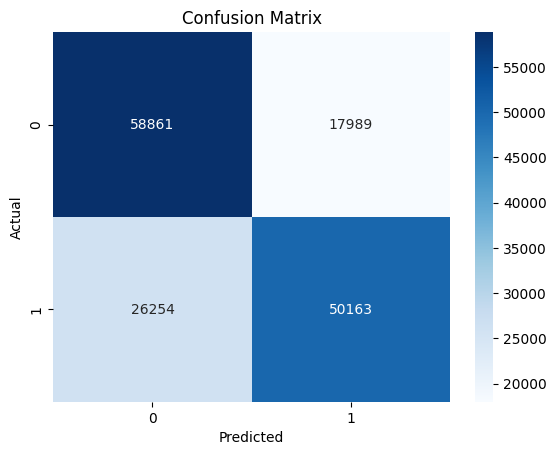

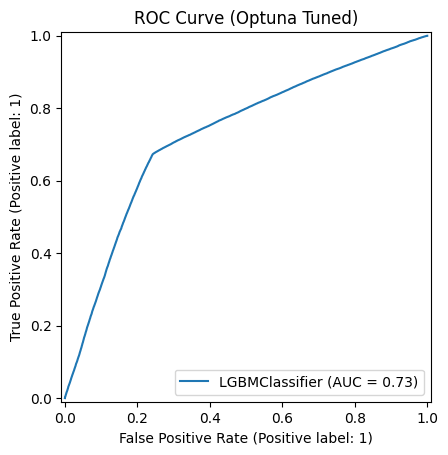

In [23]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Use the best parameters found by Optuna
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_jobs'] = -1

# Train the final model
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_opt, y_train_opt)

# Predict on validation set
y_pred = final_model.predict(X_valid_opt)
y_pred_proba = final_model.predict_proba(X_valid_opt)[:, 1]

# Evaluate performance
print("Classification Report:")
print(classification_report(y_valid_opt, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_valid_opt, y_pred_proba))

# Confusion matrix
cm = confusion_matrix(y_valid_opt, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(final_model, X_valid_opt, y_valid_opt)
plt.title("ROC Curve (Optuna Tuned)")
plt.show()


In [24]:
import pickle

# Save the model to disk
with open("lgbm_optuna_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("Model saved as lgbm_optuna_model.pkl")



Model saved as lgbm_optuna_model.pkl


In [28]:
# Select top 50 features
importances = final_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by="importance", ascending=False)

top_50_features = feature_importance_df['feature'].head(50).tolist()


In [29]:
# Keep only top 50 features
test_top_50 = test_df[top_50_features]


In [31]:
# Predict probabilities with correct feature set
y_test_pred_proba = final_model.predict_proba(test_top_50)[:, 1]

# Create submission

submission = pd.DataFrame({
    'id': test_df['id'],         # ✅ DOĞRU: 'id' sütununu doğrudan kullan
    'claim': y_test_pred_proba
})
submission.to_csv("submission.csv", index=False)



In [32]:
# For Sample CSVs

sample_df = test_df.copy()

# Keep only 'id' and top 50 features
top_50_features = [
    'f87', 'f39', 'f10', 'f27', 'f94', 'f101', 'f14', 'f52', 'f48', 'f110',
    'f24', 'f34', 'f108', 'f102', 'f29', 'f46', 'f23', 'f83', 'f65', 'f15',
    'f25', 'f118', 'f97', 'f36', 'f61', 'f3', 'f53', 'f71', 'f16', 'f74',
    'f18', 'f33', 'f21', 'f38', 'f12', 'f50', 'f43', 'f37', 'f92', 'f13',
    'f35', 'f86', 'f42', 'f17', 'f70', 'f100', 'f19', 'f31', 'f85', 'f63'
]

# If 'id' is not in your data, generate it
if 'id' not in sample_df.columns:
    sample_df['id'] = np.arange(len(sample_df))

# Create three random samples
sample1 = sample_df[['id'] + top_50_features].sample(n=100, random_state=1)
sample2 = sample_df[['id'] + top_50_features].sample(n=100, random_state=2)
sample3 = sample_df[['id'] + top_50_features].sample(n=100, random_state=3)

# Save them as CSV
sample1.to_csv("sample1.csv", index=False)
sample2.to_csv("sample2.csv", index=False)
sample3.to_csv("sample3.csv", index=False)

print("✅ Sample CSVs saved successfully.")


✅ Sample CSVs saved successfully.
